<h1>Black Friday Sales Exploratory Data Analysis</h1>
<p>My first step in this analysis is to understand the data at a deeper level. Specifically, I want to know any consumer segments and their purchase patterns. I'll look for any insights through visual and statisitcal data analysis that may lead me down a better modeling path. Analysis will be broken into the following categories:<ul><li><a href='#userAnalysis'>User Analysis</a></li><li>Product Analysis</li><li>Transaction Analysis</li>,</ul></p>

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-colorblind')

from scripts import viz,stats
from config import db_engine

from model.model import User, Product, Transaction
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import func

In [2]:
#Get Model Session
engine = create_engine(db_engine)
Session = sessionmaker(bind=engine)

#Get session object
session = Session()

<div id='userAnalysis' \>
<h2>User Analysis</h2>

In [3]:
#Load user data
usr_metrics = session.query(
    func.count(Transaction.id).label('transactionCount'),
    func.sum(Transaction.income).label('incomeTotal'),
    (func.sum(Transaction.income).label('incomeTotal')/func.count(Transaction.id).label('transactionCount')).label('avgTransaction'),
    User.id
).join(User, Transaction.user_id == User.id).group_by(User.id)

usr = session.query(
User
)

In [4]:
# Pull user metrics by user id and pull user data. Then join together for analysis
user_metrics = pd.read_sql(usr_metrics.statement,engine,index_col='id')
users = pd.read_sql(usr.statement,engine,index_col='id')
users = users.join(user_metrics)
users.head()

,gender,age,occupation,city_category,years_in_current_city,marital_status,transactionCount,incomeTotal,avgTransaction
id,,,,,,,,,
1000001,F,0-17,10,A,2,0,34,333481,9808
1000002,M,55+,16,C,4+,0,76,810353,10662
1000003,M,26-35,15,A,3,0,29,341635,11780
1000004,M,46-50,7,B,2,1,13,205987,15845
1000005,M,26-35,20,A,1,1,106,821001,7745


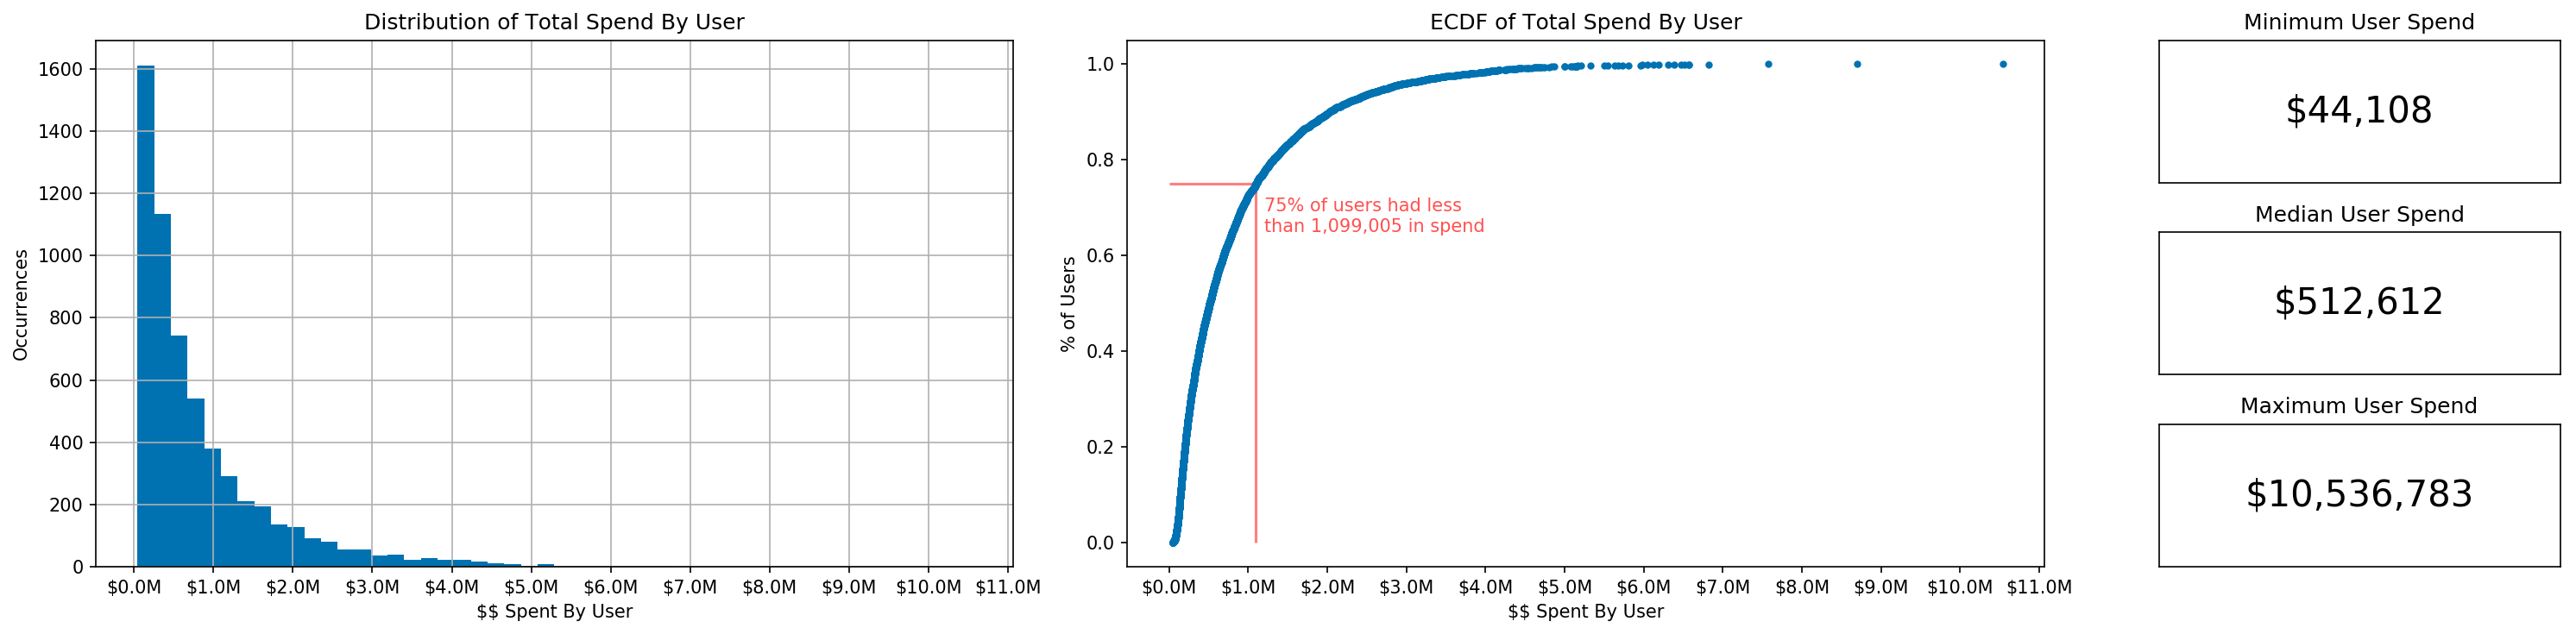

In [5]:
fig = plt.figure(figsize=(20,5),dpi=150)
subplot_grid = (3,5)

ax0 = plt.subplot2grid(subplot_grid,(0,0),rowspan=3,colspan=2)
users['incomeTotal'].hist(bins=50,ax=ax0)
ax0.xaxis.set_major_formatter(FuncFormatter(viz.axisFmtDollarsMillions))
ax0.set_title('Distribution of Total Spend By User');
ax0.set_xticks(range(0,12000000,1000000))
ax0.set_ylabel('Occurrences')
ax0.set_xlabel(r'\$$ Spent By User')

x,y = stats.ecdf(users['incomeTotal'])
ax = plt.subplot2grid(subplot_grid,(0,2),rowspan=3,colspan=2)
viz.ecdfPlot(ax=ax,x=x,y=y,x_axis_units='users',y_axis_units='in spend',perc=[.75])
ax.set_title('ECDF of Total Spend By User')
ax.set_xticks(range(0,12000000,1000000))
ax.xaxis.set_major_formatter(FuncFormatter(viz.axisFmtDollarsMillions))
ax.set_ylabel('% of Users')
ax.set_xlabel(r'\$$ Spent By User')

ax1 = plt.subplot2grid(subplot_grid,(0,4))
viz.text_box(ax=ax1,s='${:,d}'.format(users['incomeTotal'].min()));
ax1.set_title('Minimum User Spend');

ax2 = plt.subplot2grid(subplot_grid,(1,4))
viz.text_box(ax=ax2,s='${:,.0f}'.format(users['incomeTotal'].median()));
ax2.set_title('Median User Spend');

ax3 = plt.subplot2grid(subplot_grid,(2,4))
viz.text_box(ax=ax3,s='${:,d}'.format(users['incomeTotal'].max()));
ax3.set_title('Maximum User Spend');

fig.tight_layout()

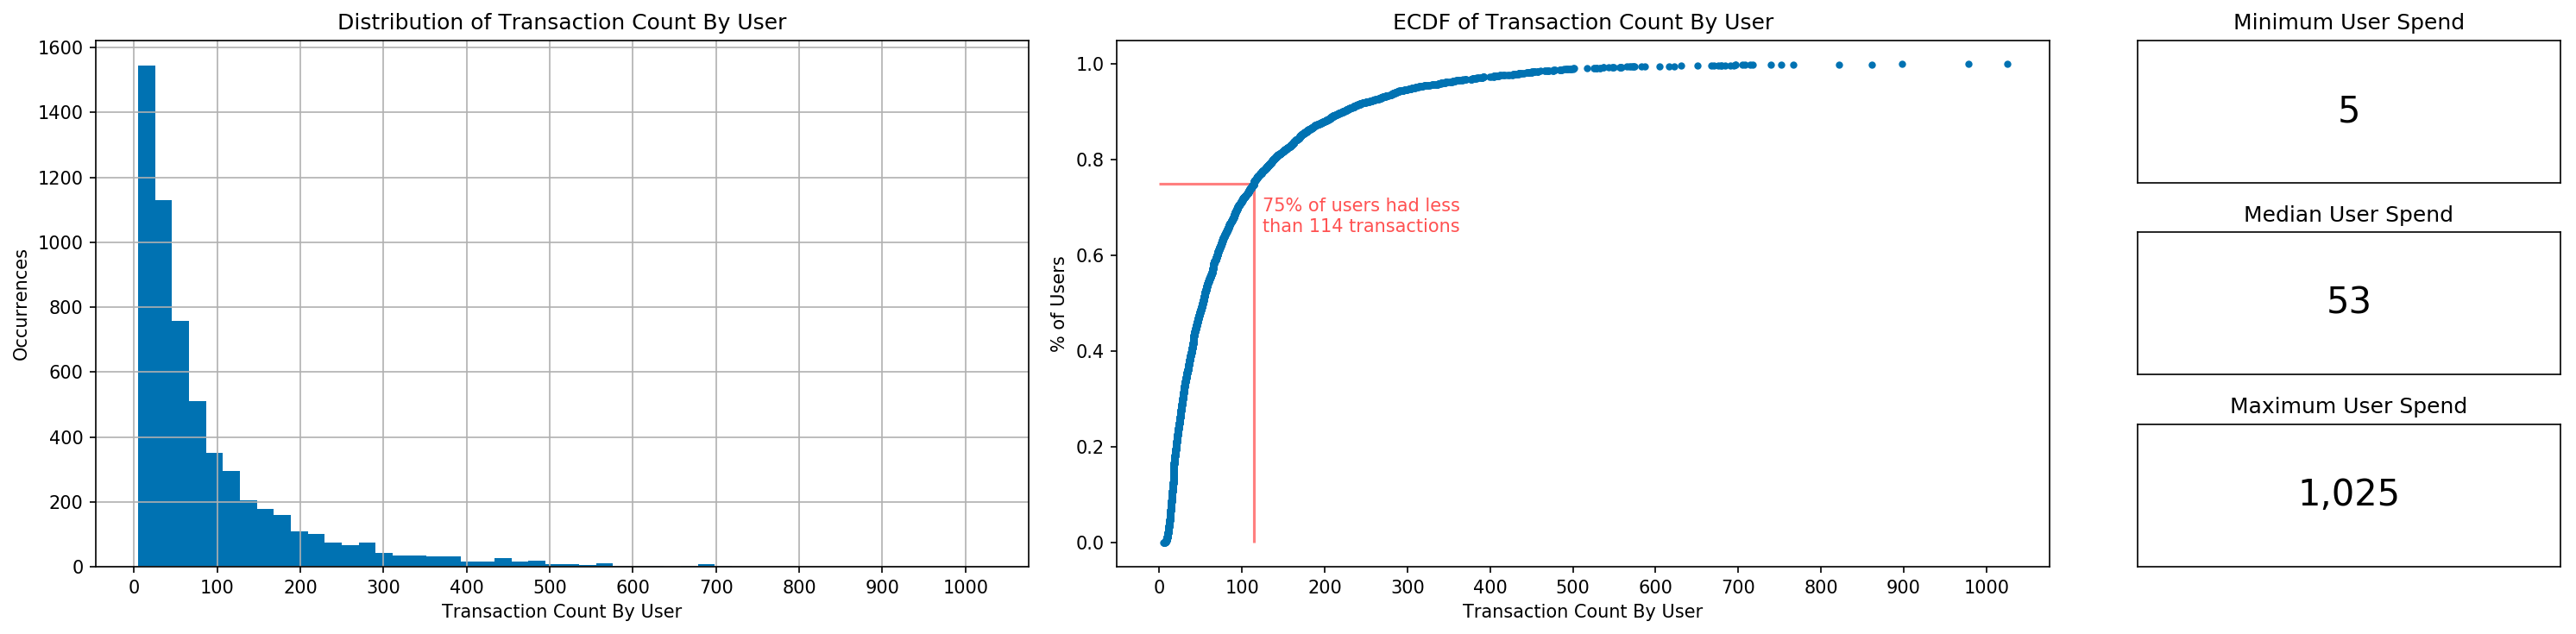

In [6]:
fig = plt.figure(figsize=(20,5),dpi=150)
subplot_grid = (3,5)

ax0 = plt.subplot2grid(subplot_grid,(0,0),rowspan=3,colspan=2)
users['transactionCount'].hist(bins=50,ax=ax0)
#ax0.xaxis.set_major_formatter(FuncFormatter(viz.axisFmtDollarsMillions))
ax0.set_title('Distribution of Transaction Count By User');
ax0.set_xticks(range(0,1100,100))
ax0.set_ylabel('Occurrences')
ax0.set_xlabel(r'Transaction Count By User')

x,y = stats.ecdf(users['transactionCount'])
ax = plt.subplot2grid(subplot_grid,(0,2),rowspan=3,colspan=2)
viz.ecdfPlot(ax=ax,x=x,y=y,x_axis_units='users',y_axis_units='transactions',perc=[.75])
ax.set_title('ECDF of Transaction Count By User')
ax.set_xticks(range(0,1100,100))
#ax.xaxis.set_major_formatter(FuncFormatter(viz.axisFmtDollarsMillions))
ax.set_ylabel('% of Users')
ax.set_xlabel(r'Transaction Count By User')


ax1 = plt.subplot2grid(subplot_grid,(0,4))
viz.text_box(ax=ax1,s='{:,d}'.format(users['transactionCount'].min()));
ax1.set_title('Minimum User Spend');

ax2 = plt.subplot2grid(subplot_grid,(1,4))
viz.text_box(ax=ax2,s='{:,.0f}'.format(users['transactionCount'].median()));
ax2.set_title('Median User Spend');

ax3 = plt.subplot2grid(subplot_grid,(2,4))
viz.text_box(ax=ax3,s='{:,d}'.format(users['transactionCount'].max()));
ax3.set_title('Maximum User Spend');

fig.tight_layout()

<p>
<b>First thing I noticed is the very high amount of spend (assumed in dollars). This doesn't make sense for a single day of sales per user (especially the median and minimum. I believe the explaination to be one of the following: </b><ol>
<li>This dataset is in another currency. As of this analysis (2019-02-23), \$512k indian rupees represent about $7200 USD
</li>
<li>
The income in the data set is sampled to protect the actual spends of users. This makes more sense since the descriptive data in this data set is masked
</li>
</ol>
<b>
Next, we can see that the distribution of the income and transaction count by user follows a power law - where 80% of users spent less than\$1.3M and had lass than 137 transactions.
<BR/><BR/>
For my next analysis, I'd like to stratify this by gender, age buckets, occupation, city_category, year in current city, and marital status. I'll use violin distribution plots would be the best way to visualize a lot of data quickly.
</b>
</p>

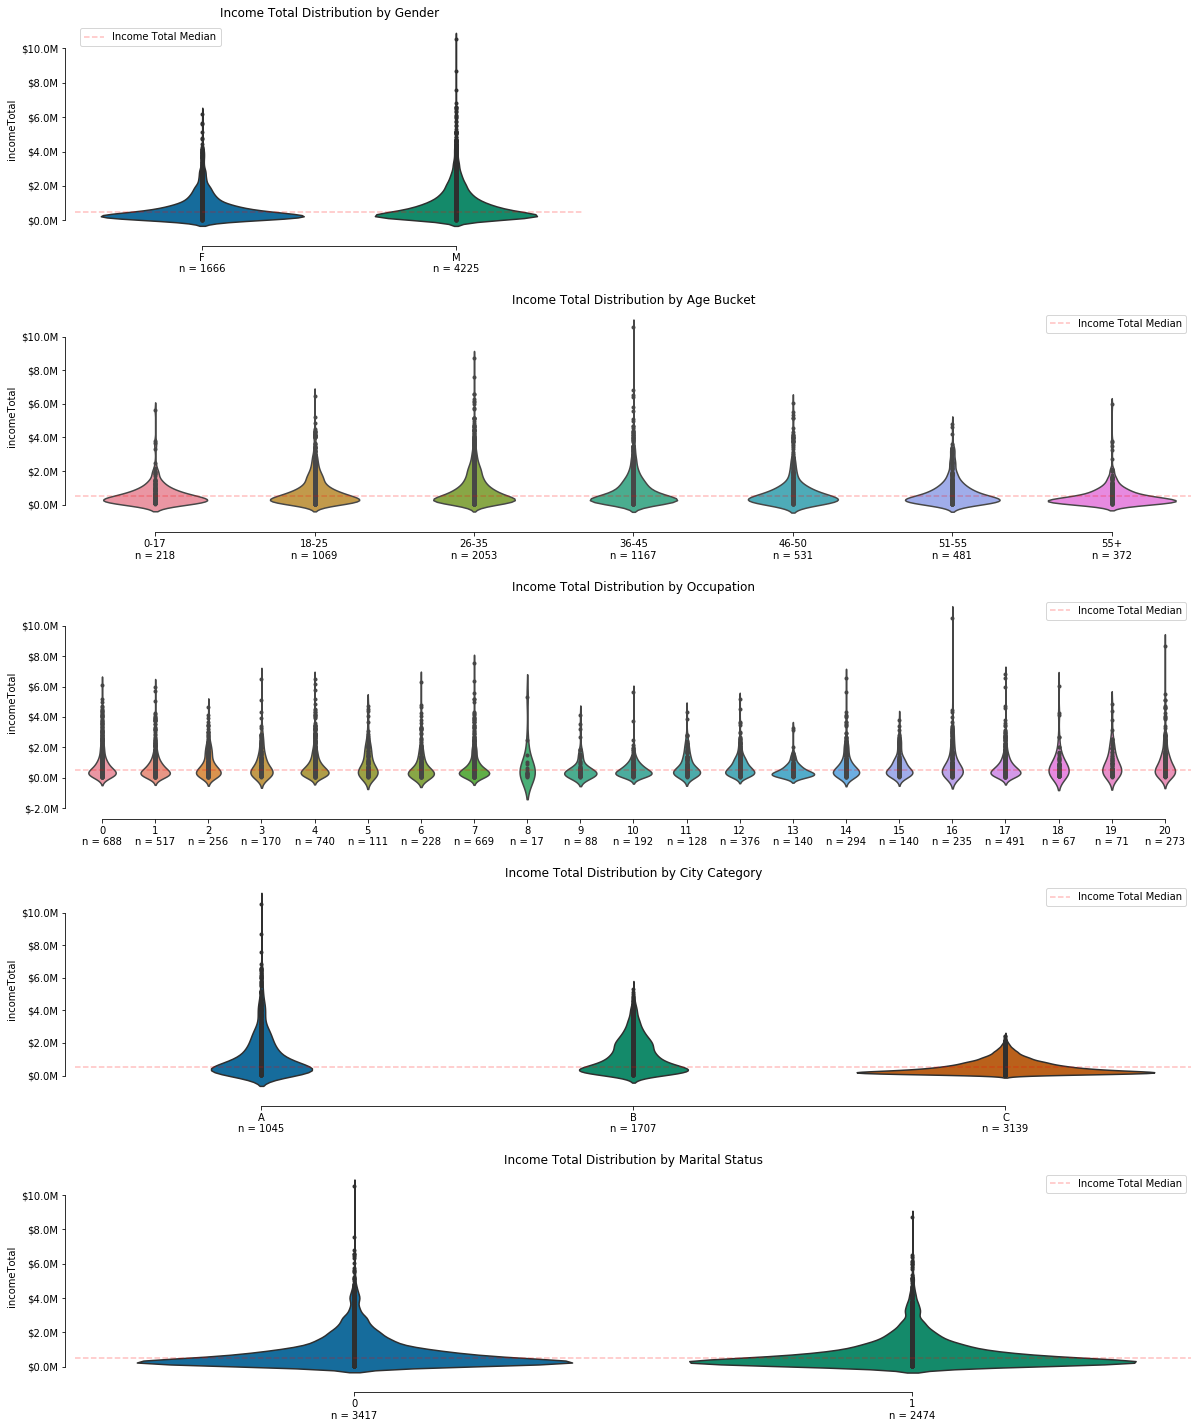

In [7]:
metric = 'incomeTotal'
title = 'Income Total'
formatter = viz.axisFmtDollarsMillions
plt.figure(figsize=(20,25))

grid = (5,2)

ax = plt.subplot2grid(grid,(0,0))
order = ['F','M']
_ = sns.violinplot(
    x='gender',
    y=metric,
    split=True,
    data=users,
    ax=ax,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('gender')['incomeTotal'].count()
xlim = ax.get_xlim()
ax.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
a = [x + '\nn = '+ str(g.loc[x]) for x in order]
ax.xaxis.set_ticklabels(a)
ax.set_title(f'{title} Distribution by Gender')
ax.set_xlabel('')
ax.legend()

ax1 = plt.subplot2grid(grid,(1,0),colspan=2)
order = ['0-17','18-25','26-35','36-45','46-50','51-55','55+']
_ = sns.violinplot(
    x='age',
    y=metric,
    split=True,
    data=users,
    ax=ax1,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('age')['incomeTotal'].count()
a = [x + '\nn = '+ str(g.loc[x]) for x in order]
ax1.xaxis.set_ticklabels(a)
ax1.set_title(f'{title} Distribution by Age Bucket')
ax1.set_xlabel('')
xlim = ax1.get_xlim()
ax1.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax1.legend()

ax2 = plt.subplot2grid(grid,(2,0),colspan=2)
order = np.arange(0,21,1)
_ = sns.violinplot(
    x='occupation',
    y=metric,
    split=True,
    data=users,
    ax=ax2,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('occupation')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax2.xaxis.set_ticklabels(a)
ax2.set_title(f'{title} Distribution by Occupation')
ax2.set_xlabel('')
xlim = ax2.get_xlim()
ax2.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax2.legend()

ax3 = plt.subplot2grid(grid,(3,0),colspan=2)
order = ['A','B','C']
_ = sns.violinplot(
    x='city_category',
    y=metric,
    split=True,
    data=users,
    ax=ax3,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('city_category')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax3.xaxis.set_ticklabels(a);
ax3.set_title(f'{title} Distribution by City Category');
ax3.set_xlabel('')
xlim = ax3.get_xlim()
ax3.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax3.legend()

ax4 = plt.subplot2grid(grid,(4,0),colspan=2)
order = np.arange(0,2,1)
_ = sns.violinplot(
    x='marital_status',
    y=metric,
    split=True,
    data=users,
    ax=ax4,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('marital_status')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax4.xaxis.set_ticklabels(a);
ax4.set_title(f'{title} Distribution by Marital Status');
ax4.set_xlabel('')
xlim = ax4.get_xlim()
ax4.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax4.legend() 

plt.subplots_adjust(wspace=None,hspace=.35)
#fig.tight_layout(pad=.5, w_pad=.5, h_pad=.5)

<H1> ADD NOTES ABOUT REVENUE DISTRIBUTION </H1>

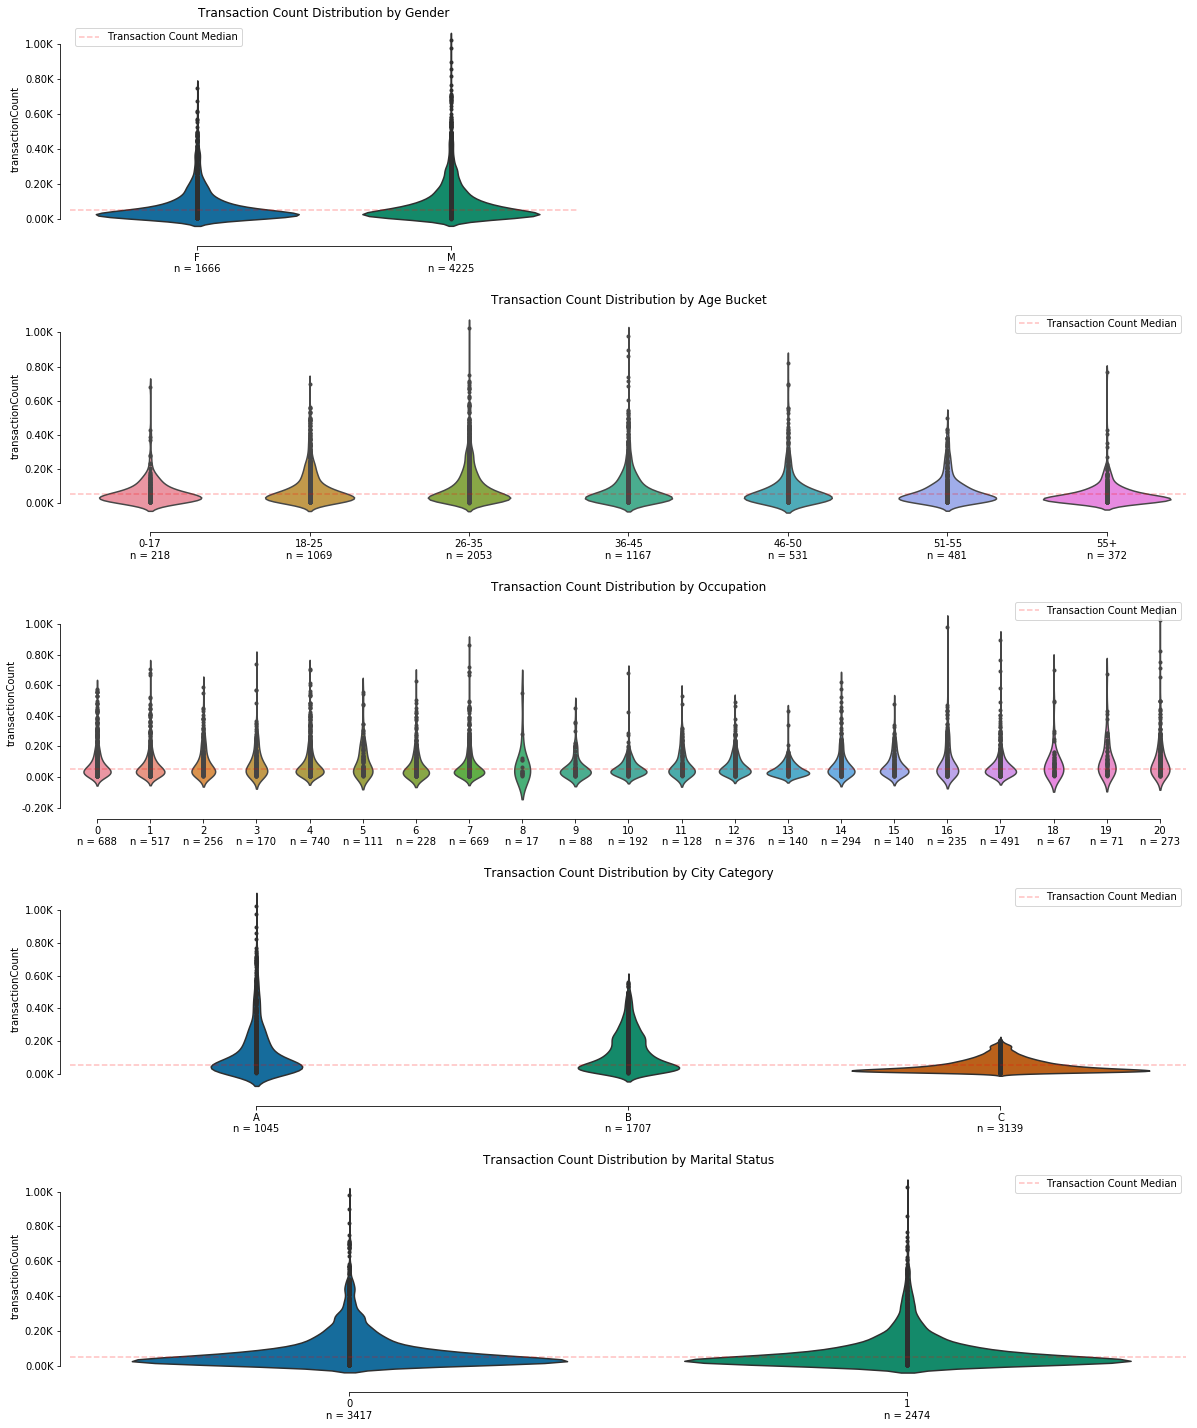

In [8]:
metric = 'transactionCount'
title = 'Transaction Count'
formatter = viz.axisFmtThousands
plt.figure(figsize=(20,25))

grid = (5,2)

ax = plt.subplot2grid(grid,(0,0))
order = ['F','M']
_ = sns.violinplot(
    x='gender',
    y=metric,
    split=True,
    data=users,
    ax=ax,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('gender')['incomeTotal'].count()
xlim = ax.get_xlim()
ax.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
a = [x + '\nn = '+ str(g.loc[x]) for x in order]
ax.xaxis.set_ticklabels(a)
ax.set_title(f'{title} Distribution by Gender')
ax.set_xlabel('')
ax.legend()

ax1 = plt.subplot2grid(grid,(1,0),colspan=2)
order = ['0-17','18-25','26-35','36-45','46-50','51-55','55+']
_ = sns.violinplot(
    x='age',
    y=metric,
    split=True,
    data=users,
    ax=ax1,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('age')['incomeTotal'].count()
a = [x + '\nn = '+ str(g.loc[x]) for x in order]
ax1.xaxis.set_ticklabels(a)
ax1.set_title(f'{title} Distribution by Age Bucket')
ax1.set_xlabel('')
xlim = ax1.get_xlim()
ax1.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax1.legend()

ax2 = plt.subplot2grid(grid,(2,0),colspan=2)
order = np.arange(0,21,1)
_ = sns.violinplot(
    x='occupation',
    y=metric,
    split=True,
    data=users,
    ax=ax2,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('occupation')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax2.xaxis.set_ticklabels(a)
ax2.set_title(f'{title} Distribution by Occupation')
ax2.set_xlabel('')
xlim = ax2.get_xlim()
ax2.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax2.legend()

ax3 = plt.subplot2grid(grid,(3,0),colspan=2)
order = ['A','B','C']
_ = sns.violinplot(
    x='city_category',
    y=metric,
    split=True,
    data=users,
    ax=ax3,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('city_category')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax3.xaxis.set_ticklabels(a);
ax3.set_title(f'{title} Distribution by City Category');
ax3.set_xlabel('')
xlim = ax3.get_xlim()
ax3.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax3.legend()

ax4 = plt.subplot2grid(grid,(4,0),colspan=2)
order = np.arange(0,2,1)
_ = sns.violinplot(
    x='marital_status',
    y=metric,
    split=True,
    data=users,
    ax=ax4,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('marital_status')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax4.xaxis.set_ticklabels(a);
ax4.set_title(f'{title} Distribution by Marital Status');
ax4.set_xlabel('')
xlim = ax4.get_xlim()
ax4.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax4.legend() 

plt.subplots_adjust(wspace=None,hspace=.35)
#fig.tight_layout(pad=.5, w_pad=.5, h_pad=.5)

<H1> ADD NOTES ABOUT TRANSACTION COUNT DISTRIBUTION </H1>

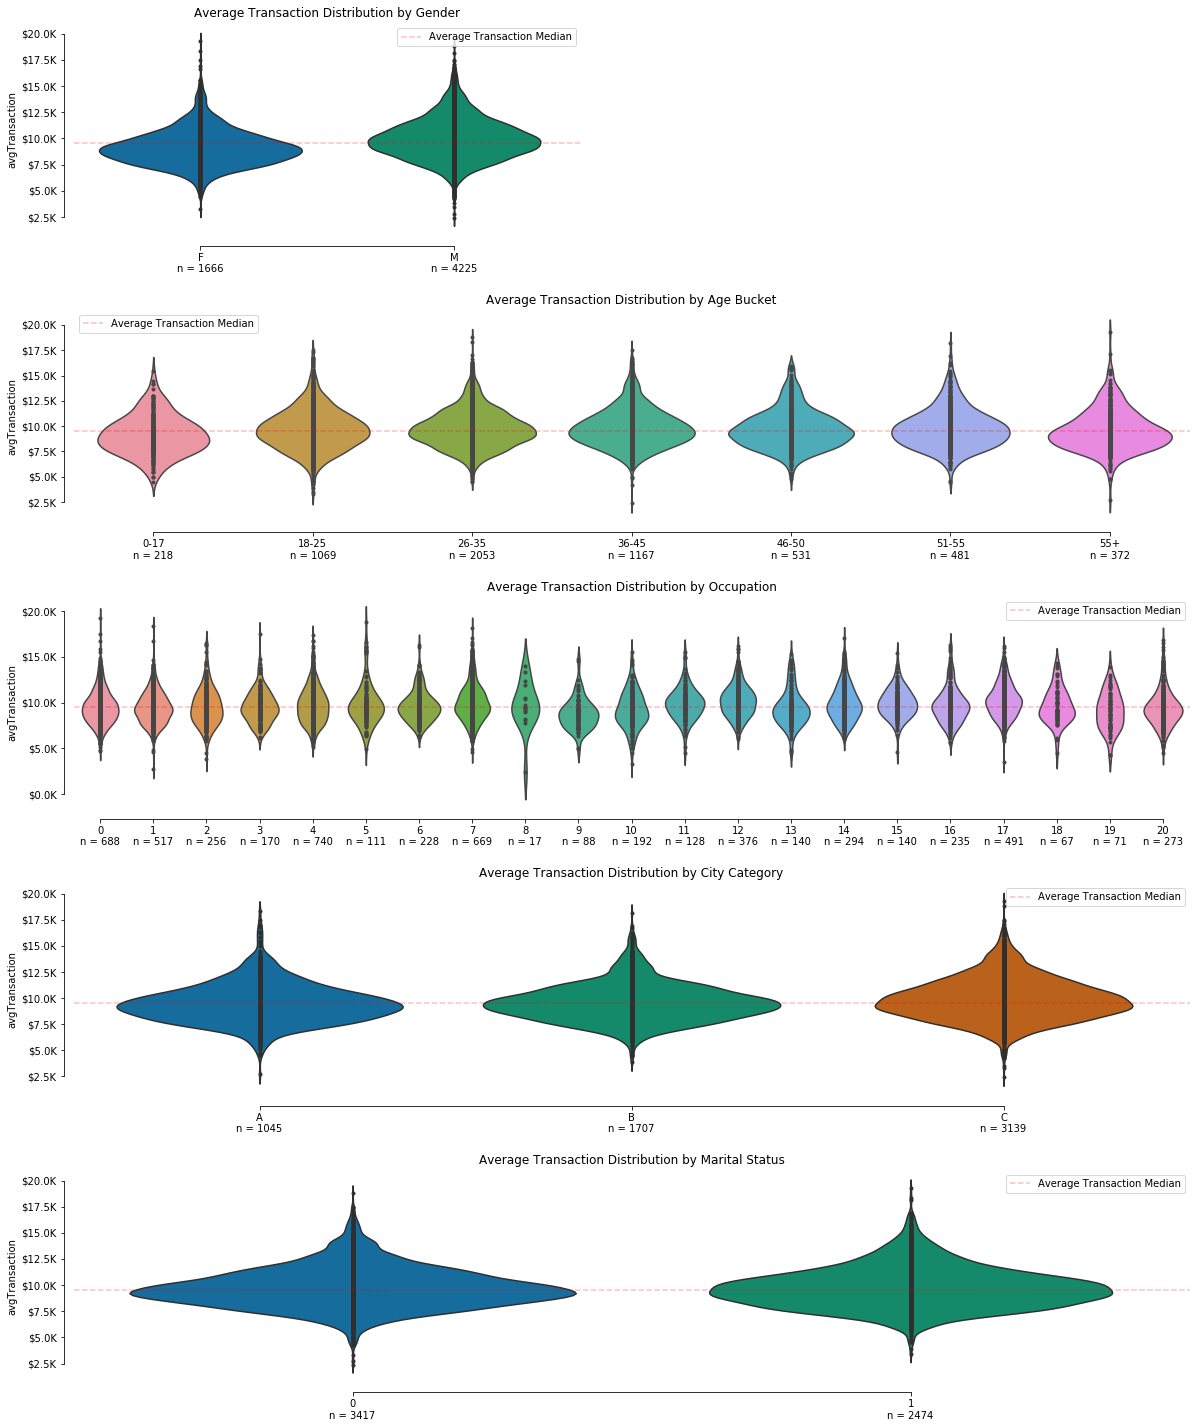

In [9]:
metric = 'avgTransaction'
title = 'Average Transaction'
formatter = viz.axisFmtDollarsThousands
plt.figure(figsize=(20,25))

grid = (5,2)

ax = plt.subplot2grid(grid,(0,0))
order = ['F','M']
_ = sns.violinplot(
    x='gender',
    y=metric,
    split=True,
    data=users,
    ax=ax,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('gender')['incomeTotal'].count()
xlim = ax.get_xlim()
ax.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
a = [x + '\nn = '+ str(g.loc[x]) for x in order]
ax.xaxis.set_ticklabels(a)
ax.set_title(f'{title} Distribution by Gender')
ax.set_xlabel('')
ax.legend()

ax1 = plt.subplot2grid(grid,(1,0),colspan=2)
order = ['0-17','18-25','26-35','36-45','46-50','51-55','55+']
_ = sns.violinplot(
    x='age',
    y=metric,
    split=True,
    data=users,
    ax=ax1,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('age')['incomeTotal'].count()
a = [x + '\nn = '+ str(g.loc[x]) for x in order]
ax1.xaxis.set_ticklabels(a)
ax1.set_title(f'{title} Distribution by Age Bucket')
ax1.set_xlabel('')
xlim = ax1.get_xlim()
ax1.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax1.legend()

ax2 = plt.subplot2grid(grid,(2,0),colspan=2)
order = np.arange(0,21,1)
_ = sns.violinplot(
    x='occupation',
    y=metric,
    split=True,
    data=users,
    ax=ax2,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('occupation')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax2.xaxis.set_ticklabels(a)
ax2.set_title(f'{title} Distribution by Occupation')
ax2.set_xlabel('')
xlim = ax2.get_xlim()
ax2.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax2.legend()

ax3 = plt.subplot2grid(grid,(3,0),colspan=2)
order = ['A','B','C']
_ = sns.violinplot(
    x='city_category',
    y=metric,
    split=True,
    data=users,
    ax=ax3,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('city_category')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax3.xaxis.set_ticklabels(a);
ax3.set_title(f'{title} Distribution by City Category');
ax3.set_xlabel('')
xlim = ax3.get_xlim()
ax3.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax3.legend()

ax4 = plt.subplot2grid(grid,(4,0),colspan=2)
order = np.arange(0,2,1)
_ = sns.violinplot(
    x='marital_status',
    y=metric,
    split=True,
    data=users,
    ax=ax4,
    order=order,
    inner='point',
    jitter=True
)
sns.despine(offset=10, trim=True);
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter))
g = users.groupby('marital_status')['incomeTotal'].count()
a = [str(x) + '\nn = '+ str(g.loc[x]) for x in order]
ax4.xaxis.set_ticklabels(a);
ax4.set_title(f'{title} Distribution by Marital Status');
ax4.set_xlabel('')
xlim = ax4.get_xlim()
ax4.hlines(users[metric].median(),xlim[0],xlim[-1],color='red',alpha=.25,linestyle='--',label=f'{title} Median')
ax4.legend() 

plt.subplots_adjust(wspace=None,hspace=.35)
#fig.tight_layout(pad=.5, w_pad=.5, h_pad=.5)

<H1> ADD NOTES ABOUT AVG TRANSACTION DISTRIBUTION </H1>